# MatchPredictor

### A neural network which predicts the outcomes of Premier League football matches

#### Importing Libraries & Packages

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data 

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import matplotlib.pyplot as plt

from time import time

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


#### Hyperparameters

In [2]:
# Data HPs
past = 3     # How many past games are taken into account for team form calculations
infer_data_percent = 0.20   
test_data_percent = 0.50

# Training HPs
rseed = 3 
batch_size = 64
lr = 0.1
num_epochs = 100
weight_decay = 0.01

# Model HPs
input_size = 12
layer_sizes = [32,32,20,3] # in_size = 12, fc1_size = 32, fc2_size = 32, fc3_size = 20, out_size = 3
act= 0                # 0 = ReLU,    1 = TanH
loss_fcn_toggle = 1   # 0 = MSELoss, 1 = BCELoss

#### Importing Match Data

In [4]:
# Imported CSVs become pandas' DataFrames

data_20_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2019-to-2020-stats.csv")
data_19_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2018-to-2019-stats.csv")
data_18_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2017-to-2018-stats.csv")
data_17_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2016-to-2017-stats.csv")
data_16_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2015-to-2016-stats.csv")
data_15_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2014-to-2015-stats.csv")
data_14_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2013-to-2014-stats.csv")
data_13_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2012-to-2013-stats.csv")

data_20_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2019-to-2020-stats.csv")
data_19_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2018-to-2019-stats.csv")
data_18_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2017-to-2018-stats.csv")
data_17_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2016-to-2017-stats.csv")
data_16_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2015-to-2016-stats.csv")
data_15_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2014-to-2015-stats.csv")
data_14_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2013-to-2014-stats.csv")
data_13_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2012-to-2013-stats.csv")

data_20_france = pd.read_csv("france-ligue-1-matches-2019-to-2020-stats.csv")
data_19_france = pd.read_csv("france-ligue-1-matches-2018-to-2019-stats.csv")
data_18_france = pd.read_csv("france-ligue-1-matches-2017-to-2018-stats.csv")
data_17_france = pd.read_csv("france-ligue-1-matches-2016-to-2017-stats.csv")
data_16_france = pd.read_csv("france-ligue-1-matches-2015-to-2016-stats.csv")
data_15_france = pd.read_csv("france-ligue-1-matches-2014-to-2015-stats.csv")
data_14_france = pd.read_csv("france-ligue-1-matches-2013-to-2014-stats.csv")

data_20_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2019-to-2020-stats.csv")
data_19_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2018-to-2019-stats.csv")
data_18_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2017-to-2018-stats.csv")
data_17_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2016-to-2017-stats.csv")
data_16_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2015-to-2016-stats.csv")
data_15_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2014-to-2015-stats.csv")
data_14_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2013-to-2014-stats.csv")

data_20_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2019-to-2020-stats.csv")
data_19_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2018-to-2019-stats.csv")
data_18_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2017-to-2018-stats.csv")
data_17_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2016-to-2017-stats.csv")
data_16_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2015-to-2016-stats.csv")
data_15_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2014-to-2015-stats.csv")
data_14_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2013-to-2014-stats.csv")


data = [data_20_prem, data_19_prem, data_18_prem, data_17_prem, data_16_prem, data_15_prem, data_14_prem, data_13_prem,
        data_20_spain, data_19_spain, data_18_spain, data_17_spain, data_16_spain, data_15_spain, data_14_spain, data_13_spain,
        data_20_france, data_19_france, data_18_france, data_17_france, data_16_france, data_15_france, data_14_france, 
        data_20_italy, data_19_italy, data_18_italy, data_17_italy, data_16_italy, data_15_italy, data_14_italy,
        data_20_germany, data_19_germany, data_18_germany, data_17_germany, data_16_germany, data_15_germany, data_14_germany]

#### DATA PREPROCSESSING  
  
Here we create the inputs for our model from the raw .csv files we collected from *footystats.org*.  
  
- Each season will be represented by a matrix.  
- Each row of this matrix will consist of the inputs that describe a single match to the neural net.  
  
In each row, the entries are as follows:  
*Note: **past** is an integer hyperparameter*  
  
**Index 0**: Home team average goals scored per game over last **past** games.  
**Index 1**:  Home team average goals conceded per game over last **past** games.  
**Index 2**:  Home team pre-match PPG.  
**Index 3**:  Home team ppg from last game (so current game isn’t included).  
**Index 4**:  Home team average number of shots on target over last **past** games.  
**Index 5**:  Home team average number of corners over last **past** games.  
**Index 6**:  Away team average goals scored per game over last **past** games.  
**Index 7**:  Away team average goals conceded per game over last **past** games.  
**Index 8**:  Away team pre-match PPG.  
**Index 9**:  Away team ppg from last game (so current game isn’t included).  
**Index 10**:  Away team average number of shots on target over last **past** games.  
**Index 11**:  Away team average number of corners over last **past** games.  
**Index 12 (LABEL)**:  0 if Home Team won, 1 if Away Team won, 2 if Draw. 
  
  
*NOTE: The first "past" weeks from each season cannot be used in training/testing as they have no previous matches to get data from.*

In [5]:
# Set up empty matrices to be filled with INPUTS & LABELS.
# Once filled with values, each row will represent the inputs/label combo that describe a match to the NN.
    
prem_20 = np.zeros((380-(past*10),13))
prem_19 = np.zeros((380-(past*10),13))
prem_18 = np.zeros((380-(past*10),13))
prem_17 = np.zeros((380-(past*10),13))
prem_16 = np.zeros((380-(past*10),13))
prem_15 = np.zeros((380-(past*10),13))
prem_14 = np.zeros((380-(past*10),13))
prem_13 = np.zeros((380-(past*10),13))

spain_20 = np.zeros((380-(past*10),13))
spain_19 = np.zeros((380-(past*10),13))
spain_18 = np.zeros((380-(past*10),13))
spain_17 = np.zeros((380-(past*10),13))
spain_16 = np.zeros((380-(past*10),13))
spain_15 = np.zeros((380-(past*10),13))
spain_14 = np.zeros((380-(past*10),13))
spain_13 = np.zeros((380-(past*10),13))

france_20 = np.zeros((380-(past*10),13))
france_19 = np.zeros((380-(past*10),13))
france_18 = np.zeros((380-(past*10),13))
france_17 = np.zeros((380-(past*10),13))
france_16 = np.zeros((380-(past*10),13))
france_15 = np.zeros((380-(past*10),13))
france_14 = np.zeros((380-(past*10),13))

italy_20 = np.zeros((380-(past*10),13))
italy_19 = np.zeros((380-(past*10),13))
italy_18 = np.zeros((380-(past*10),13))
italy_17 = np.zeros((380-(past*10),13))
italy_16 = np.zeros((380-(past*10),13))
italy_15 = np.zeros((380-(past*10),13))
italy_14 = np.zeros((380-(past*10),13))

germany_20 = np.zeros((306-(past*9),13))
germany_19 = np.zeros((306-(past*9),13))
germany_18 = np.zeros((306-(past*9),13))
germany_17 = np.zeros((306-(past*9),13))
germany_16 = np.zeros((306-(past*9),13))
germany_15 = np.zeros((306-(past*9),13))
germany_14 = np.zeros((306-(past*9),13))


input_seasons = [prem_20, prem_19, prem_18, prem_17, prem_16, prem_15, prem_14, prem_13,
                 spain_20, spain_19, spain_18, spain_17, spain_16, spain_15, spain_14, spain_13,
                 france_20, france_19, france_18, france_17, france_16, france_15, france_14, 
                 italy_20, italy_19, italy_18, italy_17, italy_16, italy_15, italy_14,
                 germany_20, germany_19, germany_18, germany_17, germany_16, germany_15, germany_14]


season_idx = 0
for season in data:
    
    week = past + 1
    input_season = input_seasons[season_idx]
    
    if season_idx < 30: # if any league other than German league...
        weeks_in_season = 38
        
    if season_idx >= 30: # if German league...
        weeks_in_season = 34
    
    while week <= weeks_in_season:
        
        match_count = 0                      # counts up to match_total for each week
        
        if season_idx < 30:
            match_total = 10                 # each week has 10 matches in every league except German.
            
        if season_idx >= 30:
            match_total = 9                  # German league has 9 matches in a given week.
            
        
        row_idx = (week-1)*match_total       # index of the first match of new week

        
        while match_count < match_total:
    
            match = season.iloc[[row_idx]]                     # saving current match
            
             # getting match LABEL (match result)
            if (match.iat[0,12] > match.iat[0,13]):            
                    result = 0   # home team win
            elif (match.iat[0,12] < match.iat[0,13]):
                    result = 1   # away team win
            else:
                    result = 2   # draw
                    
            
            home_team = season.at[row_idx,'home_team_name']    # saving home team name
            away_team = season.at[row_idx,'away_team_name']    # saving away team name
            
            total_home_goals = 0                               # counts total goals scored by home team over "past" matches
            total_away_goals = 0                               # counts total goals scored by away team over "past" matches
            
            total_home_conceded = 0                            # counts total goals scored against home team over "past" matches 
            total_away_conceded = 0                            # counts total goals scored against away team over "past" matches
            
            total_home_shotson = 0                             # counts total shots on target taken by home team over...
            total_away_shotson = 0                             # counts total shots on target taken by away team over...
            
            total_home_corners = 0                             # counts total corners taken by home team over...
            total_away_corners = 0                             # counts total corners taken by away team over...
            
            home_PPG_pre = match.iat[0,8]                      # home team pre-match points per game (PPG)
            away_PPG_pre = match.iat[0,9]                      # away team pre-match points per game (PPG)
            
            
            previous = 1                                       # counts up to "past"
            
            
            while previous <= past:

                home_match_prev = season.loc[(season['home_team_name'] == home_team) & (season['Game Week'] == week-previous)]   # picking out home team's previous match
                h_sc_idx = 12       # home team score index
                h_shon_idx = 32     # home shots on target index
                h_corn_idx = 20     # home corners index
                h_ppg_idx = 10
                
                away_match_prev = season.loc[(season['away_team_name'] == away_team) & (season['Game Week'] == week-previous)]   # picking out away team's previous match
                a_sc_idx = 13       # away team score index
                a_shon_idx = 33     # away team shots on target index
                a_corn_idx = 21     # away corners index
                a_ppg_idx = 11
                
                # if home team name was not found in 'home_team_name' column...
                if (home_match_prev.size == 0):
                    home_match_prev = season.loc[(season['away_team_name'] == home_team) & (season['Game Week'] == week-previous)]   # picking out home team's previous match
                    h_sc_idx = 13      # home team score index
                    h_shon_idx = 33    # home shots on target index
                    h_corn_idx = 21    # home corners index
                    h_ppg_idx = 11
                    
                # if away team name was not found in 'away_team_name' column...
                if (away_match_prev.size == 0):
                    away_match_prev = season.loc[(season['home_team_name'] == away_team) & (season['Game Week'] == week-previous)]   # picking out away team's previous match
                    a_sc_idx = 12      # away team score index
                    a_shon_idx = 32    # away team shots on target index
                    a_corn_idx = 20    # away corners index
                    a_ppg_idx = 10
                    
                # if loop is 1 match in the past...   
                if previous == 1:
                    home_PPG = home_match_prev.iat[0,h_ppg_idx]
                    away_PPG = away_match_prev.iat[0,a_ppg_idx]
                    
                #print(home_team, 'goals scored in week', week-previous, '= ', home_match_prev.iat[0,h_sc_idx])
                total_home_goals += home_match_prev.iat[0,h_sc_idx]
                total_away_goals += away_match_prev.iat[0,a_sc_idx]
                
                #print(home_team, 'goals conceded in week', week-previous, '=', home_match_prev.iat[0,a_sc_idx])
                total_home_conceded += home_match_prev.iat[0,a_sc_idx]
                total_away_conceded += away_match_prev.iat[0,h_sc_idx]
                
                total_home_shotson += home_match_prev.iat[0,h_shon_idx]
                total_away_shotson += away_match_prev.iat[0,a_shon_idx]
                
                total_home_corners += home_match_prev.iat[0,h_corn_idx]
                total_away_corners += away_match_prev.iat[0,a_corn_idx]
                
                
                previous += 1

            in_idx = row_idx - (past*match_total)
            input_season[in_idx][0] = total_home_goals/past          # input INDEX 0 (home team avg. goals over "past")
            input_season[in_idx][1] = total_home_conceded/past       # input INDEX 1 (home team avg. conceded goals over "past")
            input_season[in_idx][2] = home_PPG_pre                   # input INDEX 2 (home team pre-match PPG: PPG in current season)
            input_season[in_idx][3] = home_PPG                       # input INDEX 3 (home team PPG including past seasons)
            input_season[in_idx][4] = total_home_shotson/past        # input INDEX 4 (home team avg. shots on target over "past")
            input_season[in_idx][5] = total_home_corners/past        # input INDEX 5 (home team avg. corner kicks over "past")
            input_season[in_idx][6] = total_away_goals/past          # input INDEX 6 (away team avg. goals over "past")
            input_season[in_idx][7] = total_away_conceded/past       # input INDEX 7 (away team avg. conceded goals over "past")
            input_season[in_idx][8] = away_PPG_pre                   # input INDEX 8 (away team pre-match PPG: PPG in current season)
            input_season[in_idx][9] = away_PPG                       # input INDEX 9 (away team PPG including past seasons)
            input_season[in_idx][10] = total_away_shotson/past       # input INDEX 10 (away team avg. shots on target over "past")
            input_season[in_idx][11] = total_away_corners/past       # input INDEX 11 (away team avg. corner kicks over "past")
            input_season[in_idx][12] = result                        # label INDEX 12 (match result)
            
            if (week == past+1) or (week == weeks_in_season):
                print(' SEASON:',season_idx+1,'\n WEEK:',week,'\n MATCH:',match_count+1,'\n',input_season[in_idx],'\n \n')
            
            row_idx += 1
            match_count += 1

        week += 1
        
    season_idx += 1
    

# SEASONS 1-8    ->  PREMIER LEAGUE (England)
# SEASONS 9-16   ->  LA LIGA        (Spain)
# SEASONS 17-23  ->  LIGUE 1        (France)
# SEASONS 24-30  ->  SERIE-A        (Italy)
# SEASONS 31-37  ->  BUNDESLIGA     (Germany)

 SEASON: 1 
 WEEK: 4 
 MATCH: 1 
 [1.         1.66666667 0.         1.63       4.33333333 5.66666667
 2.         1.         1.         1.95       4.33333333 5.66666667
 2.        ] 
 

 SEASON: 1 
 WEEK: 4 
 MATCH: 2 
 [1.33333333 1.         1.         1.58       7.66666667 5.66666667
 1.         1.33333333 1.         1.74       3.66666667 6.33333333
 2.        ] 
 

 SEASON: 1 
 WEEK: 4 
 MATCH: 3 
 [0.66666667 0.66666667 1.         1.05       4.         3.66666667
 1.33333333 1.66666667 0.         1.26       5.66666667 3.33333333
 0.        ] 
 

 SEASON: 1 
 WEEK: 4 
 MATCH: 4 
 [1.         0.66666667 1.         1.32       3.         7.
 1.33333333 2.         3.         1.11       5.66666667 4.
 0.        ] 
 

 SEASON: 1 
 WEEK: 4 
 MATCH: 5 
 [3.33333333 2.66666667 1.         1.79       8.66666667 6.33333333
 1.33333333 2.         3.         1.16       4.33333333 6.
 0.        ] 
 

 SEASON: 1 
 WEEK: 4 
 MATCH: 6 
 [0.66666667 0.33333333 0.         0.95       4.         5.3333333

 SEASON: 3 
 WEEK: 38 
 MATCH: 1 
 [0.33333333 2.         1.44       1.47       5.33333333 5.33333333
 0.66666667 1.33333333 0.83       1.37       6.         9.
 1.        ] 
 

 SEASON: 3 
 WEEK: 38 
 MATCH: 2 
 [2.33333333 0.33333333 1.28       0.95       4.66666667 6.
 1.33333333 0.66666667 0.72       0.95       4.         4.33333333
 0.        ] 
 

 SEASON: 3 
 WEEK: 38 
 MATCH: 3 
 [0.33333333 1.         1.28       0.74       3.         1.66666667
 3.33333333 1.         0.72       2.47       7.33333333 4.
 1.        ] 
 

 SEASON: 3 
 WEEK: 38 
 MATCH: 4 
 [0.66666667 1.         2.22       1.68       4.33333333 5.
 0.66666667 0.33333333 0.61       1.53       4.66666667 4.
 0.        ] 
 

 SEASON: 3 
 WEEK: 38 
 MATCH: 5 
 [1.33333333 0.66666667 2.44       1.79       4.33333333 6.66666667
 0.66666667 1.         0.78       1.42       6.33333333 2.
 0.        ] 
 

 SEASON: 3 
 WEEK: 38 
 MATCH: 6 
 [0.33333333 1.33333333 1.39       0.84       2.66666667 5.33333333
 1.         0.33

 SEASON: 6 
 WEEK: 38 
 MATCH: 1 
 [1.33333333 1.66666667 2.11       1.79       6.         5.33333333
 1.66666667 0.66666667 1.06       1.32       3.66666667 2.66666667
 0.        ] 
 

 SEASON: 6 
 WEEK: 38 
 MATCH: 2 
 [1.66666667 2.66666667 1.17       0.89       4.         3.33333333
 0.33333333 0.33333333 0.61       1.         3.33333333 4.33333333
 1.        ] 
 

 SEASON: 6 
 WEEK: 38 
 MATCH: 3 
 [0.66666667 1.66666667 2.56       2.         6.33333333 4.33333333
 1.33333333 0.66666667 1.         1.05       4.33333333 3.33333333
 0.        ] 
 

 SEASON: 6 
 WEEK: 38 
 MATCH: 4 
 [1.33333333 1.33333333 1.         1.42       3.33333333 6.
 1.66666667 1.33333333 1.33       1.68       4.33333333 6.
 0.        ] 
 

 SEASON: 6 
 WEEK: 38 
 MATCH: 5 
 [1.33333333 2.         1.56       1.         6.         8.66666667
 0.66666667 1.33333333 1.56       1.74       3.33333333 7.33333333
 1.        ] 
 

 SEASON: 6 
 WEEK: 38 
 MATCH: 6 
 [0.33333333 1.33333333 1.06       0.79       2.3333

 SEASON: 9 
 WEEK: 38 
 MATCH: 1 
 [0.66666667 1.         1.5        0.63       3.33333333 3.
 1.         0.66666667 1.61       2.63       4.66666667 7.
 1.        ] 
 

 SEASON: 9 
 WEEK: 38 
 MATCH: 2 
 [1.66666667 1.66666667 1.61       1.47       4.         2.33333333
 1.66666667 0.33333333 0.83       1.42       5.         4.33333333
 0.        ] 
 

 SEASON: 9 
 WEEK: 38 
 MATCH: 3 
 [0.66666667 2.         1.22       0.89       6.33333333 6.
 1.33333333 1.         0.56       1.63       5.66666667 5.
 0.        ] 
 

 SEASON: 9 
 WEEK: 38 
 MATCH: 4 
 [1.33333333 0.33333333 2.28       1.47       3.         2.33333333
 1.33333333 1.33333333 1.33       1.63       5.         7.
 2.        ] 
 

 SEASON: 9 
 WEEK: 38 
 MATCH: 5 
 [0.         1.33333333 0.61       0.68       4.66666667 5.33333333
 1.33333333 2.         0.72       1.21       4.         6.
 2.        ] 
 

 SEASON: 9 
 WEEK: 38 
 MATCH: 6 
 [2.         1.66666667 1.67       1.21       5.         4.33333333
 1.         1.66

 SEASON: 12 
 WEEK: 4 
 MATCH: 7 
 [0.66666667 1.         0.         1.05       4.33333333 5.
 1.33333333 2.66666667 0.         1.47       9.         9.
 0.        ] 
 

 SEASON: 12 
 WEEK: 4 
 MATCH: 8 
 [1.         0.33333333 1.         1.58       5.         5.
 1.         1.33333333 3.         1.84       4.33333333 5.33333333
 0.        ] 
 

 SEASON: 12 
 WEEK: 4 
 MATCH: 9 
 [2.33333333 2.33333333 1.         1.42       2.         2.
 3.33333333 2.33333333 3.         2.42       7.66666667 6.66666667
 1.        ] 
 

 SEASON: 12 
 WEEK: 4 
 MATCH: 10 
 [1.         0.66666667 1.         1.37       3.         2.
 0.66666667 0.66666667 1.         1.37       4.         3.33333333
 2.        ] 
 

 SEASON: 12 
 WEEK: 38 
 MATCH: 1 
 [0.66666667 2.66666667 0.89       0.21       3.33333333 3.33333333
 0.66666667 1.66666667 1.33       1.53       6.         5.
 1.        ] 
 

 SEASON: 12 
 WEEK: 38 
 MATCH: 2 
 [1.         1.         1.         0.63       5.33333333 6.
 0.66666667 3.       

 SEASON: 15 
 WEEK: 4 
 MATCH: 9 
 [1.         2.         1.         0.74       3.66666667 4.33333333
 1.         1.33333333 0.         1.42       3.33333333 6.
 2.        ] 
 

 SEASON: 15 
 WEEK: 4 
 MATCH: 10 
 [1.66666667 1.33333333 3.         1.42       1.66666667 5.
 1.66666667 1.33333333 3.         1.32       5.66666667 7.
 0.        ] 
 

 SEASON: 15 
 WEEK: 38 
 MATCH: 1 
 [0.33333333 0.33333333 1.28       1.         5.         6.33333333
 1.66666667 1.         1.17       1.42       3.33333333 4.
 0.        ] 
 

 SEASON: 15 
 WEEK: 38 
 MATCH: 2 
 [ 2.          2.66666667  2.56        2.          8.33333333 10.66666667
  0.66666667  1.          0.89        1.37        4.          6.33333333
  0.        ] 
 

 SEASON: 15 
 WEEK: 38 
 MATCH: 3 
 [ 1.66666667  1.66666667  2.72        1.95        7.33333333 10.33333333
  0.66666667  1.33333333  2.22        2.58        5.33333333  7.
  2.        ] 
 

 SEASON: 15 
 WEEK: 38 
 MATCH: 4 
 [0.66666667 1.33333333 1.67       0.84      

 SEASON: 18 
 WEEK: 38 
 MATCH: 1 
 [0.33333333 1.         1.28       0.63       3.33333333 2.66666667
 1.         1.         0.61       0.84       7.33333333 6.
 0.        ] 
 

 SEASON: 18 
 WEEK: 38 
 MATCH: 2 
 [0.66666667 2.33333333 1.28       1.16       3.66666667 3.
 2.         1.         1.33       2.16       5.         7.
 2.        ] 
 

 SEASON: 18 
 WEEK: 38 
 MATCH: 3 
 [1.         2.         0.94       0.84       4.66666667 2.66666667
 0.         1.         0.61       1.42       3.66666667 6.66666667
 1.        ] 
 

 SEASON: 18 
 WEEK: 38 
 MATCH: 4 
 [0.66666667 2.66666667 1.06       0.63       5.         3.
 1.33333333 2.33333333 0.94       1.11       4.66666667 4.66666667
 0.        ] 
 

 SEASON: 18 
 WEEK: 38 
 MATCH: 5 
 [2.         2.         1.89       1.26       6.66666667 5.66666667
 1.         0.66666667 1.5        1.68       4.66666667 3.33333333
 0.        ] 
 

 SEASON: 18 
 WEEK: 38 
 MATCH: 6 
 [1.66666667 1.66666667 1.72       0.89       4.33333333 2.333

 SEASON: 21 
 WEEK: 38 
 MATCH: 1 
 [0.         0.66666667 1.44       1.26       3.33333333 3.33333333
 1.         1.         0.67       1.32       5.66666667 6.33333333
 1.        ] 
 

 SEASON: 21 
 WEEK: 38 
 MATCH: 2 
 [1.66666667 3.         1.83       1.53       6.         5.
 3.         1.         1.22       1.42       4.         7.
 0.        ] 
 

 SEASON: 21 
 WEEK: 38 
 MATCH: 3 
 [0.66666667 1.33333333 1.89       1.26       4.33333333 3.
 0.33333333 0.         1.33       1.74       8.33333333 8.66666667
 1.        ] 
 

 SEASON: 21 
 WEEK: 38 
 MATCH: 4 
 [1.         1.         1.39       1.         3.33333333 5.33333333
 1.33333333 0.66666667 1.22       2.         5.         7.
 1.        ] 
 

 SEASON: 21 
 WEEK: 38 
 MATCH: 5 
 [1.         3.         0.5        0.42       5.         6.
 1.         0.33333333 1.5        1.05       5.         4.66666667
 2.        ] 
 

 SEASON: 21 
 WEEK: 38 
 MATCH: 6 
 [0.         2.         1.39       0.95       4.         4.66666667
 1

 SEASON: 24 
 WEEK: 38 
 MATCH: 1 
 [0.66666667 2.33333333 0.72       0.58       4.66666667 7.
 0.66666667 2.66666667 1.06       1.16       5.33333333 4.66666667
 2.        ] 
 

 SEASON: 24 
 WEEK: 38 
 MATCH: 2 
 [2.33333333 1.33333333 1.67       1.74       5.33333333 4.
 1.         0.33333333 1.11       1.32       6.33333333 2.66666667
 0.        ] 
 

 SEASON: 24 
 WEEK: 38 
 MATCH: 3 
 [1.33333333 1.         2.11       2.11       6.         5.33333333
 1.66666667 1.         2.22       2.05       6.66666667 6.66666667
 1.        ] 
 

 SEASON: 24 
 WEEK: 38 
 MATCH: 4 
 [ 1.          1.33333333  1.67        1.53        5.66666667  6.33333333
  3.          0.66666667  1.83        2.37       11.          7.66666667
  0.        ] 
 

 SEASON: 24 
 WEEK: 38 
 MATCH: 5 
 [1.         1.         2.78       1.74       7.33333333 6.66666667
 3.66666667 3.66666667 1.83       1.89       7.66666667 5.66666667
 1.        ] 
 

 SEASON: 24 
 WEEK: 38 
 MATCH: 6 
 [0.66666667 3.33333333 0.56     

 SEASON: 27 
 WEEK: 38 
 MATCH: 1 
 [1.         0.66666667 2.06       1.68       7.         6.66666667
 1.66666667 2.33333333 1.11       1.21       4.         3.
 0.        ] 
 

 SEASON: 27 
 WEEK: 38 
 MATCH: 2 
 [1.33333333 2.33333333 1.44       0.79       4.         4.33333333
 1.66666667 1.33333333 1.83       2.89       6.33333333 9.
 1.        ] 
 

 SEASON: 27 
 WEEK: 38 
 MATCH: 3 
 [2.         3.66666667 1.83       0.58       6.         4.33333333
 1.66666667 1.66666667 1.39       2.         5.33333333 8.
 0.        ] 
 

 SEASON: 27 
 WEEK: 38 
 MATCH: 4 
 [4.         1.66666667 2.56       2.         9.         5.66666667
 1.         0.66666667 0.61       1.32       4.         5.66666667
 0.        ] 
 

 SEASON: 27 
 WEEK: 38 
 MATCH: 5 
 [1.66666667 3.         1.67       0.95       6.33333333 4.
 4.         0.66666667 2.22       2.26       9.33333333 6.33333333
 1.        ] 
 

 SEASON: 27 
 WEEK: 38 
 MATCH: 6 
 [0.66666667 1.         0.67       0.58       5.         4.
 1

 MATCH: 10 
 [2.         1.66666667 3.         1.05       4.66666667 4.
 3.         0.66666667 3.         2.26       5.66666667 4.
 1.        ] 
 

 SEASON: 30 
 WEEK: 38 
 MATCH: 1 
 [2.33333333 2.33333333 1.67       0.68       4.33333333 5.
 1.33333333 2.66666667 1.         1.37       5.66666667 5.33333333
 2.        ] 
 

 SEASON: 30 
 WEEK: 38 
 MATCH: 2 
 [2.         2.         1.33       0.26       2.66666667 3.33333333
 1.         1.         0.78       1.89       3.33333333 5.66666667
 0.        ] 
 

 SEASON: 30 
 WEEK: 38 
 MATCH: 3 
 [1.66666667 0.33333333 3.         2.37       4.         3.66666667
 0.33333333 1.33333333 0.61       1.47       3.33333333 5.
 0.        ] 
 

 SEASON: 30 
 WEEK: 38 
 MATCH: 4 
 [1.         1.66666667 1.44       0.79       2.         2.
 1.         1.66666667 2.06       2.53       5.         6.33333333
 0.        ] 
 

 SEASON: 30 
 WEEK: 38 
 MATCH: 5 
 [2.         2.33333333 1.83       1.05       7.66666667 8.
 0.33333333 1.66666667 0.67      

 SEASON: 33 
 WEEK: 34 
 MATCH: 1 
 [3.33333333 0.66666667 2.75       2.35       9.         5.
 1.66666667 0.         0.88       2.         4.         2.
 1.        ] 
 

 SEASON: 33 
 WEEK: 34 
 MATCH: 2 
 [2.66666667 1.66666667 2.13       1.06       7.66666667 6.66666667
 2.         1.         1.5        1.82       8.         5.33333333
 0.        ] 
 

 SEASON: 33 
 WEEK: 34 
 MATCH: 3 
 [2.         1.66666667 1.38       1.24       4.33333333 4.
 2.         3.         1.19       1.82       6.33333333 6.
 1.        ] 
 

 SEASON: 33 
 WEEK: 34 
 MATCH: 4 
 [1.33333333 2.         1.5        0.53       7.33333333 3.
 1.66666667 1.33333333 1.19       1.29       5.66666667 3.66666667
 0.        ] 
 

 SEASON: 33 
 WEEK: 34 
 MATCH: 5 
 [1.66666667 1.33333333 2.         1.65       7.33333333 4.
 1.33333333 2.33333333 1.31       1.65       6.33333333 3.33333333
 0.        ] 
 

 SEASON: 33 
 WEEK: 34 
 MATCH: 6 
 [0.         1.66666667 1.63       1.53       5.         4.33333333
 1.3333333

 SEASON: 36 
 WEEK: 34 
 MATCH: 1 
 [0.33333333 1.66666667 2.5        2.12       6.33333333 6.
 1.         1.33333333 1.         1.41       3.66666667 4.
 0.        ] 
 

 SEASON: 36 
 WEEK: 34 
 MATCH: 2 
 [1.33333333 1.         1.69       0.94       3.33333333 5.66666667
 0.66666667 1.         0.94       1.65       4.33333333 5.33333333
 0.        ] 
 

 SEASON: 36 
 WEEK: 34 
 MATCH: 3 
 [2.33333333 0.33333333 2.44       1.59       4.         4.33333333
 0.66666667 0.66666667 0.94       1.82       3.66666667 5.33333333
 1.        ] 
 

 SEASON: 36 
 WEEK: 34 
 MATCH: 4 
 [0.66666667 1.33333333 1.69       0.82       6.         6.
 0.33333333 0.33333333 0.81       1.29       1.         3.33333333
 0.        ] 
 

 SEASON: 36 
 WEEK: 34 
 MATCH: 5 
 [1.66666667 1.33333333 1.19       0.88       3.66666667 5.66666667
 1.33333333 1.33333333 0.81       1.24       6.66666667 5.33333333
 0.        ] 
 

 SEASON: 36 
 WEEK: 34 
 MATCH: 6 
 [1.         0.66666667 1.81       0.65       3.      

In [38]:
# Joining all season input data into one dataset
data_full_np = np.concatenate((input_seasons), axis=0)

# Turn numpy array back into pd.DataFrame
columns = ['h_goals','h_conceded','h_prePPG','h_avgPPG','h_shotsOn','h_corners',
           'a_goals','a_conceded','a_prePPG','a_avgPPG','a_shotsOn','a_corners',
           'outcome']

data_full = pd.DataFrame(data_full_np, columns=columns)

#Print 'outcome' column sums to determine dataset balance
print('The numbers of match outcomes (Home Team Wins, Away Team Wins, Draws):', data_full["outcome"].value_counts())

#============================ BALANCE THE DATASET ==========================
# draws are the under-represented class, so...
# set home wins count = draws count
# set away wins count = draws count

data_full_home  = data_full[data_full["outcome"]==0.0]
data_full_away = data_full[data_full["outcome"]==1.0]
data_full_tie = data_full[data_full["outcome"]==2.0]

data_full_home = data_full_home.sample(len(data_full_tie), random_state=1)
data_full_away = data_full_away.sample(len(data_full_tie), random_state=1)



subsets = [data_full_home,data_full_away,data_full_tie]
data_full = pd.concat(subsets)
print(data_full["outcome"].value_counts(),'\n')

data_full_np = data_full.values

#==========================================================================

# Get a better idea of what our data looks like BEFORE NORMALIZATION
def verbose_print(data):     # helper function
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(data.head())
       
# print("\n \n Data characteristics:")
# verbose_print(data_full.describe())

# Turn 'outcome' column values into one hot-encoded form
lb = LabelBinarizer()
y = lb.fit_transform(data_full_np[:,12])   # y is vector of 1-hot encoded labels

#y = data_full_np[:,12]
#X = data_full_np[:,:12]                    # x is matrix of inputs (need to be normalized still)

# Normalize continuous inputs
X = data_full.drop(columns=['outcome'])


for feature in X:
  mean = X[feature].mean()
  std = X[feature].std()
  X[feature] = X[feature] - mean
  X[feature] = X[feature]/std

X = X.values
X = train_test_split(X,test_size=infer_data_percent,random_state=1)
y = train_test_split(y,test_size=infer_data_percent,random_state=1)

X_train = X[0]  # extracting training inputs
y_train = y[0]  # extracting training labels
X_infer = train_test_split(X[1],test_size = test_data_percent,random_state=1) # splitting inputs into validation and test sets
y_infer = train_test_split(y[1],test_size = test_data_percent,random_state=1) # splitting labels into validation and test sets

The numbers of match outcomes (Home Team Wins, Away Team Wins, Draws): 0.0    5654
1.0    3643
2.0    3156
Name: outcome, dtype: int64
2.0    3156
1.0    3156
0.0    3156
Name: outcome, dtype: int64 



## Multi-Layer Perceptron Model

In [52]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, layer_sizes, act):
        
        # Current parameters are:
        # input_size = size of input data vector
        # layer_sizes = list of each layer size, last layer size MUST = 3, ex: [32,32,20,3]
        
        super(MultiLayerPerceptron, self).__init__()
        
        # setting layer sizes
        self.linears = nn.ModuleList()
        self.linears.append(nn.Linear(input_size,layer_sizes[0]))    # first layer created manually
        for k in range(len(layer_sizes)-1):
            self.linears.append(nn.Linear(layer_sizes[k], layer_sizes[k+1])) # creating all other layers
            
        # setting activation function
        if act == 0:
          self.act = nn.ReLU()
        elif act == 1:  
          self.act = nn.Tanh()
        
        self.out = nn.Softmax(dim=1)

        ''' # manual method
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,20)
        self.fc4 = nn.Linear(20,3) 
        '''

    def forward(self, x):
        
        layer_count = len(self.linears)
        
        for i in range(layer_count-1):
            x = self.act(self.linears[i](x))
        
        x = self.out(self.linears[layer_count-1](x))
      
        ''' # manual method
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        '''
        return x

### Helper Functions

#### Dataloader creation


In [8]:
# MatchDataset turns matrix-style datasets into map-style datasets
class MatchDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index],self.y[index]
    

def load_data(batch_size):

    train_dataset = MatchDataset(X_train,y_train)
    valid_dataset = MatchDataset(X_infer[0],y_infer[0])
    test_dataset = MatchDataset(X_infer[1],y_infer[1])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    return train_loader, valid_loader, test_loader





#### Get prediction from output

In [9]:
def get_preds(z):
  
  out = np.zeros(z.shape)
  #inputs: output of model
  #outputs: corresponding output to prediction
  max_idxs = torch.max(z,1)[1]
  for entry,idx in enumerate(max_idxs,0):
      for val in range(3):
        if val == idx:
          out[entry][val] = 1

  return out

#### Accuracy function

In [34]:
def accuracy(preds, labels):
    #inputs: preds: array, labels:array 
    #output: overall accuracy
    
    correct = 0
    
    '''   # for BCEwithLogitsLoss
    for batch in range(len(preds)):
        idx = labels[batch].int()
        if (preds[batch][idx] == 1):
            correct += 1
    '''
    for batch in range(len(preds)):
        for i in range(3):
            if (preds[batch][i] == 1) and (labels[batch][i] == 1):
                correct += 1     
    
    return (correct/len(preds))

#### Validate 

In [11]:
def validate(model,val_loader,loss_fcn):
  val_acc=[]
  val_loss=[]
  for epoch in range(0,num_epochs):
    for i,data in enumerate(val_loader,0): #iterate over val_loader, start idx=0
      inputs,labels = data

      z = model(inputs.float())  #z is size=3 

      preds = get_preds(z) #preds used for accuracy
        
      loss = loss_fcn(input=z, target=labels.float())  # FOR MSE LOSS

      val_acc.append(accuracy(preds,labels))
      val_loss.append(loss.item())
       
  ValLoss = sum(val_loss)/len(val_loss)
  ValAcc = sum(val_acc) / len(val_acc)
  
  return ValAcc, ValLoss

#### Plotting Function

In [13]:
def plot(epoch, train_var, val_var,xlabel,ylabel):
    plt.plot(epoch, train_var, label = 'train')
    plt.plot(epoch, val_var, label = 'validation')
    plt.title(str(xlabel) + ' vs. '+ str(ylabel))
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
    plt.legend()
    plt.show()

#### MLP loader

In [1]:
def load_MLP(lr):
    
    #add optimizer,loss functions as a hyperparameters
    model = MultiLayerPerceptron(input_size,layer_sizes,act)
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=weight_decay)

    if loss_fcn_toggle == 0:
        loss_fcn = nn.MSELoss()
    if loss_fcn_toggle == 1:
        loss_fcn = nn.BCELoss()
    
    return model,optimizer,loss_fcn

##Training Loop

Epoch: 1
train acc: 0.32515625
val acc: 0.31447265625
train loss: 0.6420800089836121
val loss: 0.6402718184888363
Epoch: 2
train acc: 0.334296875
val acc: 0.33046875
train loss: 0.6398890763521194
val loss: 0.6368982935696841
Epoch: 3
train acc: 0.32015625000000003
val acc: 0.321640625
train loss: 0.6384809613227844
val loss: 0.636438384950161
Epoch: 4
train acc: 0.333203125
val acc: 0.3275
train loss: 0.6371476128697395
val loss: 0.6355587666481733
Epoch: 5
train acc: 0.3140625
val acc: 0.3466015625
train loss: 0.6366625502705574
val loss: 0.6345019572228193
Epoch: 6
train acc: 0.355546875
val acc: 0.37857421875
train loss: 0.6358270272612572
val loss: 0.6344266515225172
Epoch: 7
train acc: 0.373984375
val acc: 0.42791015625
train loss: 0.6352214142680168
val loss: 0.633417289108038
Epoch: 8
train acc: 0.419140625
val acc: 0.4433203125
train loss: 0.6349178701639175
val loss: 0.633327934294939
Epoch: 9
train acc: 0.419375
val acc: 0.4247265625
train loss: 0.6339480727910995
val loss: 

Epoch: 73
train acc: 0.48140625
val acc: 0.44375
train loss: 0.5908659622073174
val loss: 0.6206647161580622
Epoch: 74
train acc: 0.49640625
val acc: 0.45966796875
train loss: 0.5896657258272171
val loss: 0.6184239675849676
Epoch: 75
train acc: 0.4925
val acc: 0.4575
train loss: 0.5893840119242668
val loss: 0.6169326312094927
Epoch: 76
train acc: 0.4875
val acc: 0.450625
train loss: 0.5880973637104034
val loss: 0.616872927788645
Epoch: 77
train acc: 0.490546875
val acc: 0.46046875
train loss: 0.5908036530017853
val loss: 0.6144780762121081
Epoch: 78
train acc: 0.48921875
val acc: 0.45134765625
train loss: 0.5931504741311073
val loss: 0.6212849556654692
Epoch: 79
train acc: 0.5075000000000001
val acc: 0.4559765625
train loss: 0.5863033533096313
val loss: 0.6186004359088838
Epoch: 80
train acc: 0.493359375
val acc: 0.44642578125
train loss: 0.5878396704792976
val loss: 0.6200018992088735
Epoch: 81
train acc: 0.487265625
val acc: 0.44642578125
train loss: 0.5902496203780174
val loss: 0.62

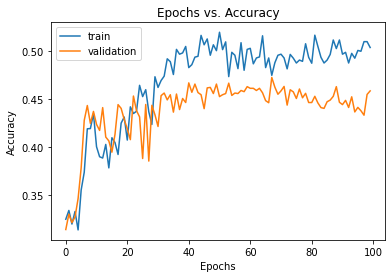

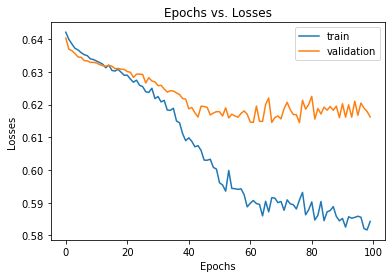

Max training accuracy 0.519453125
Min training loss 0.5816879868507385 

Max Validation accuracy 0.47248046875
Min Validation loss 0.6144780762121081 

Test accuracy 0.45929509163740123
Test loss 0.604596084645435 



In [79]:
def train(rseed,lr,num_epochs):

    torch.manual_seed(rseed)

    model,optimizer,loss_fcn = load_MLP(lr)   #initialize model
    
    train_loader, valid_loader, test_loader = load_data(batch_size) # get dataloaders

    #records for plotting 
    TrainAccRec = []
    TrainLossRec = []
    ValAccRec = []  
    ValLossRec = []
    
    tic = time()
 
# ========================================TRAINING LOOP =========================================# 
    for epoch in range(0,num_epochs):
        batch_count = 0
        train_acc_sum = 0
        train_loss_sum = 0
        for i,data in enumerate(train_loader,0): #iterate over train_loader, start idx=0
            inputs,labels = data

            optimizer.zero_grad()  #initialize the gradients to zero  

            z = model(inputs.float())  #z is size=3

            preds = get_preds(z) #preds used for accuracy
            
            loss = loss_fcn(input=z, target=labels.float())

            loss.backward() #get gradients 

            optimizer.step() #update parameters

            train_acc = accuracy(preds,labels)
            train_loss = loss.item()

            #add to overall records
            train_acc_sum += train_acc
            train_loss_sum += train_loss
            
            batch_count += 1

        TrainAccRec.append(train_acc_sum/batch_count)
        TrainLossRec.append(train_loss_sum/batch_count)
        val_acc, val_loss = validate(model, valid_loader,loss_fcn)
        ValAccRec.append(val_acc)
        ValLossRec.append(val_loss)
        
        print("Epoch:",epoch+1)
        print("train acc:",train_acc_sum/batch_count)
        print("val acc:",val_acc)
        print("train loss:", train_loss_sum/batch_count)
        print("val loss:", val_loss)

    toc = time()
    print("Total training time:", toc-tic)

    test_acc, test_loss = validate(model,test_loader,loss_fcn)

    
    #plottting
    e = np.arange(0,num_epochs)
    plot(e,TrainAccRec,ValAccRec,'Epochs','Accuracy')
    plot(e,TrainLossRec,ValLossRec,'Epochs','Losses')
    print("Max training accuracy",max(TrainAccRec))
    print("Min training loss",min(TrainLossRec),"\n")
    print("Max Validation accuracy",max(ValAccRec))
    print("Min Validation loss",min(ValLossRec),"\n")
    print("Test accuracy",test_acc)
    print("Test loss",test_loss,"\n")
 

train(rseed,lr,num_epochs)  